In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import tqdm as tqdm
import glob 

import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16

In [102]:
# !unzip archive.zip
root_dir = 'dataset'
image_label = os.listdir(root_dir)
image_label.remove('test.csv')
image_label

['sunrise', 'shine', 'cloudy', 'alien_test', 'foggy', 'rainy']

In [103]:
sunrise_path = glob.glob(f"{root_dir}/{image_label[0]}/*")
plt.imread(sunrise_path[0]).shape

(147, 344, 3)

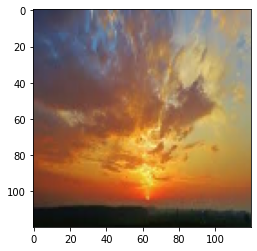

In [104]:
img = cv2.imread(sunrise_path[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (120,120))
plt.imshow(img)

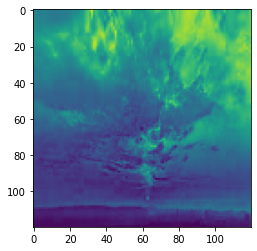

In [105]:
plt.imshow(img[:,:,0]) # R
plt.imshow(img[:,:,1]) # G
plt.imshow(img[:,:,2]) # B

In [106]:
# fig, axes = plt.subplots(nrows=1, ncols=len(img_label)+1, figsize=(20,5))

# for i, img_label in enumerate(image_label):
#     wfiles = glob.glob(f"{root_dir}/{img_label}/*")
#     print(f"{img_label} : {len(wfiles)} {wfiles[0]}")
#     axes[i].imshow(plt.imread(wfiles[0]))
#     axes[i].set_title(img_label)

In [107]:
def image_read_and_resize(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (120,120))
    return img

In [108]:
def img_folder_read(img_label):
    temp_files = []
    temp_labels = []
    wfiles = sorted(glob.glob(f"{root_dir}/{img_label}/*"))
    for w_img in wfiles:
        try:
            temp_files.append(image_read_and_resize(w_img))
            temp_labels.append(img_label)
        except:
            continue
            
    return temp_files, temp_labels

img_samples, sample_labels = img_folder_read('shine')
len(img_samples), len(sample_labels)

(249, 249)

In [109]:
x_train_img = []
x_test_img = []
y_train_img = []
y_test_img = []

for img_label in tqdm.tqdm(image_label):
    x, y = img_folder_read(img_label)
    if img_label == 'alien_test':
        x_test_img.extend(x)
        y_test_img.extend(y)
    else:
        x_train_img.extend(x)
        y_train_img.extend(y)
        
len(x_train_img), len(y_train_img), len(x_test_img), len(y_test_img)

100% 6/6 [00:08<00:00,  1.38s/it]


(1498, 1498, 30, 30)

In [110]:
# x_array
# y_array
x_train_img = np.array(x_train_img)
x_test_img = np.array(x_test_img)
y_train_img = np.array(y_train_img)
y_test_img = np.array(y_test_img)

print(f"x trian image shape: {x_train_img.shape}")
print(f"y trian image shape: {y_train_img.shape}")
print(f"x test image shape: {x_test_img.shape}")
print(f"y test image shape: {y_test_img.shape}")

x trian image shape: (1498, 120, 120, 3)
y trian image shape: (1498,)
x test image shape: (30, 120, 120, 3)
y test image shape: (30,)


In [111]:
from sklearn.model_selection import train_test_split

x_train_raw, x_valid_raw, y_train_raw, y_valid_raw = train_test_split(
                                                            x_train_img, 
                                                            y_train_img, 
                                                            test_size=0.2, 
                                                            random_state=42,
                                                            stratify=y_train_img
                                                            )

print(f"x trian raw shape: {x_train_raw.shape}")
print(f"y trian raw shape: {y_train_raw.shape}")
print(f"x valid raw shape: {x_valid_raw.shape}")
print(f"y valid raw shape: {y_valid_raw.shape}")

x trian raw shape: (1198, 120, 120, 3)
y trian raw shape: (1198,)
x valid raw shape: (300, 120, 120, 3)
y valid raw shape: (300,)


In [112]:
x_train = x_train_raw / 255
x_valid = x_valid_raw / 255
x_test = x_test_img / 255

print(f"x train normalized shape: {x_train.shape}")
print(f"x valid normalized shape: {x_valid.shape}")
print(f"x test normalized shape: {x_test.shape}")


x train normalized shape: (1198, 120, 120, 3)
x valid normalized shape: (300, 120, 120, 3)
x test normalized shape: (30, 120, 120, 3)


In [113]:
# LabelBinarizer 를 사용하여 'cloudy', 'shine', 'sunrise', 'rainy', 'foggy' 형태의 분류를 숫자로 변경합니다.
# y_train
# y_test
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train_raw)
y_valid = lb.transform(y_valid_raw)

print(f"y train one hot encoded shape: {y_train.shape}")
print(f"y valid one hot encoded shape: {y_valid.shape}")
print(lb.classes_)

y train one hot encoded shape: (1198, 5)
y valid one hot encoded shape: (300, 5)
['cloudy' 'foggy' 'rainy' 'shine' 'sunrise']


In [114]:
pd.Series(y_train_raw).value_counts(normalize=True)

sunrise    0.233723
cloudy     0.200334
foggy      0.200334
rainy      0.199499
shine      0.166110
dtype: float64

In [115]:
pd.Series(y_valid_raw).value_counts(normalize=True)

sunrise    0.233333
foggy      0.200000
cloudy     0.200000
rainy      0.200000
shine      0.166667
dtype: float64

In [116]:
model = Sequential()
# input
# input_shape = x_train[0].shape
model.add(Conv2D(filters=16, kernel_size=(3,3), padding = 'same', activation='relu', input_shape=(120,120,3)))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding = 'same', activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))
# batchnormalization

# Fully connected layer
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))

# output
model.add(Dense(len(y_train[0]), activation='softmax'))

In [117]:
# summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 120, 120, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 60, 60, 16)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 60, 60, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 30, 30, 32)       

In [118]:
"""
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))

model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(5,activation='softmax'))
"""

"\nvgg = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))\n\nmodel = Sequential()\nmodel.add(vgg)\nmodel.add(Flatten())\nmodel.add(Dense(5,activation='softmax'))\n"

In [119]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [120]:
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)

In [121]:
print(f'x_train.shape : {x_train.shape}')
print(f'y_train.shape : {y_train.shape}')

x_train.shape : (1198, 120, 120, 3)
y_train.shape : (1198, 5)


In [122]:
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=earlystop
)

Epoch 1/100
30/30 [==============================] - 1s 13ms/step - loss: 1.4443 - accuracy: 0.3580 - val_loss: 1.3109 - val_accuracy: 0.5000
Epoch 2/100
30/30 [==============================] - 0s 7ms/step - loss: 1.0901 - accuracy: 0.5814 - val_loss: 1.1658 - val_accuracy: 0.5167
Epoch 3/100
30/30 [==============================] - 0s 7ms/step - loss: 0.9735 - accuracy: 0.6190 - val_loss: 1.0477 - val_accuracy: 0.6125
Epoch 4/100
30/30 [==============================] - 0s 6ms/step - loss: 0.8227 - accuracy: 0.7025 - val_loss: 0.9912 - val_accuracy: 0.6417
Epoch 5/100
30/30 [==============================] - 0s 6ms/step - loss: 0.7355 - accuracy: 0.7255 - val_loss: 0.8800 - val_accuracy: 0.7000
Epoch 6/100
30/30 [==============================] - 0s 6ms/step - loss: 0.6959 - accuracy: 0.7390 - val_loss: 0.9502 - val_accuracy: 0.6667
Epoch 7/100
30/30 [==============================] - 0s 6ms/step - loss: 0.6292 - accuracy: 0.7672 - val_loss: 0.8311 - val_accuracy: 0.7125
Epoch 8/100


In [123]:
history2 = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_valid, y_valid),
    callbacks=[earlystop]
)

Epoch 1/100
38/38 [==============================] - 0s 10ms/step - loss: 0.2697 - accuracy: 0.9240 - val_loss: 0.6232 - val_accuracy: 0.7933
Epoch 2/100
38/38 [==============================] - 0s 6ms/step - loss: 0.2529 - accuracy: 0.9265 - val_loss: 0.6252 - val_accuracy: 0.7933
Epoch 3/100
38/38 [==============================] - 0s 6ms/step - loss: 0.2090 - accuracy: 0.9366 - val_loss: 0.6388 - val_accuracy: 0.7767
Epoch 4/100
38/38 [==============================] - 0s 6ms/step - loss: 0.2040 - accuracy: 0.9374 - val_loss: 0.6468 - val_accuracy: 0.7767
Epoch 5/100
38/38 [==============================] - 0s 6ms/step - loss: 0.1712 - accuracy: 0.9549 - val_loss: 0.6780 - val_accuracy: 0.7833
Epoch 6/100
38/38 [==============================] - 0s 6ms/step - loss: 0.1894 - accuracy: 0.9416 - val_loss: 0.6750 - val_accuracy: 0.7633
Epoch 00006: early stopping


<AxesSubplot:>

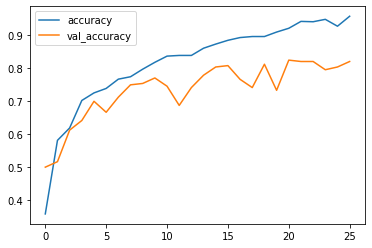

In [124]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

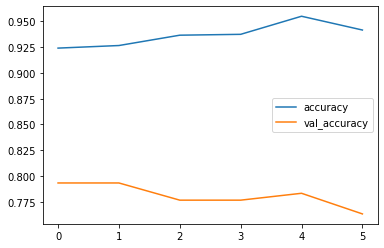

In [125]:
pd.DataFrame(history2.history)[['accuracy','val_accuracy']].plot()

In [126]:
sorted(glob.glob(f"{root_dir}/alien_test/*"))

['dataset/alien_test/Cloud_1.png',
 'dataset/alien_test/Cloud_2.jpg',
 'dataset/alien_test/Cloud_3.jpeg',
 'dataset/alien_test/Cloud_4.jpg',
 'dataset/alien_test/foggy_1.jpg',
 'dataset/alien_test/foggy_10.jpg',
 'dataset/alien_test/foggy_2.jpg',
 'dataset/alien_test/foggy_3.jpg',
 'dataset/alien_test/foggy_4.jpg',
 'dataset/alien_test/foggy_5.jpg',
 'dataset/alien_test/foggy_6.jpg',
 'dataset/alien_test/foggy_7.jpg',
 'dataset/alien_test/foggy_8.jpg',
 'dataset/alien_test/foggy_9.jpg',
 'dataset/alien_test/rain_1.jpg',
 'dataset/alien_test/rain_2.png',
 'dataset/alien_test/rain_3.jpg',
 'dataset/alien_test/rain_4.jpg',
 'dataset/alien_test/rain_5.jpg',
 'dataset/alien_test/rain_6.jpg',
 'dataset/alien_test/shine_1.jpg',
 'dataset/alien_test/shine_2.jpg',
 'dataset/alien_test/shine_3.jpg',
 'dataset/alien_test/sunrise_1.jpg',
 'dataset/alien_test/sunrise_2.jpg',
 'dataset/alien_test/sunrise_3.jpg',
 'dataset/alien_test/sunrise_4.jpg',
 'dataset/alien_test/sunrise_5.jpg',
 'dataset/alie

In [141]:
y_pred = model.predict(x_test)
y_predict = np.argmax(y_pred, axis=1)

In [136]:
test = pd.read_csv('dataset/test.csv')
accuracy = (test['labels'] == np.argmax(y_pred, axis=1)).mean()
accuracy

0.7333333333333333

accuracy : 0.7333333333333333


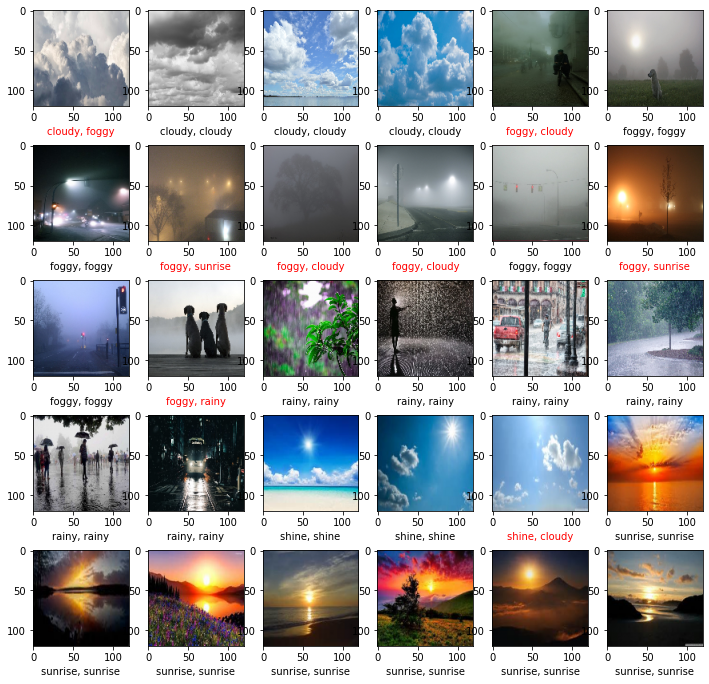

In [145]:
print(f'accuracy : {accuracy}')
plt.figure(figsize=(12,12))
for i, row in test.iterrows():
    plt.subplot(5,6,i+1)
    plt.imshow(x_test[i])
    test_label = lb.classes_[row['labels']]
    predict_label = lb.classes_[y_predict[i]]
    c = 'k'
    if predict_label != test_label:
        c = 'r'
    plt.xlabel(f"{test_label}, {predict_label}", c=c)

## DATA AUGMENTATION

In [152]:
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [153]:
model = Sequential()

# data augmentation
model.add(data_augmentation)
# input
# input_shape = x_train[0].shape
model.add(Conv2D(filters=16, kernel_size=(3,3), padding = 'same', activation='relu', input_shape=(120,120,3)))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding = 'same', activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))
# batchnormalization

# Fully connected layer
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))

# output
model.add(Dense(len(y_train[0]), activation='softmax'))

In [154]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [155]:
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=earlystop
)

Epoch 1/100
30/30 [==============================] - 2s 15ms/step - loss: 1.5833 - accuracy: 0.2171 - val_loss: 1.4856 - val_accuracy: 0.0750
Epoch 2/100
30/30 [==============================] - 0s 7ms/step - loss: 1.3741 - accuracy: 0.2756 - val_loss: 1.3744 - val_accuracy: 0.2708
Epoch 3/100
30/30 [==============================] - 0s 7ms/step - loss: 1.2254 - accuracy: 0.4635 - val_loss: 1.3341 - val_accuracy: 0.3708
Epoch 4/100
30/30 [==============================] - 0s 7ms/step - loss: 1.2099 - accuracy: 0.4948 - val_loss: 1.1853 - val_accuracy: 0.5750
Epoch 5/100
30/30 [==============================] - 0s 7ms/step - loss: 1.1123 - accuracy: 0.5136 - val_loss: 1.0984 - val_accuracy: 0.6083
Epoch 6/100
30/30 [==============================] - 0s 7ms/step - loss: 1.0653 - accuracy: 0.5553 - val_loss: 1.0834 - val_accuracy: 0.6250
Epoch 7/100
30/30 [==============================] - 0s 7ms/step - loss: 1.0266 - accuracy: 0.5522 - val_loss: 1.0764 - val_accuracy: 0.6083
Epoch 8/100
